In [1]:
import warnings
warnings.simplefilter('ignore')

In [2]:
from ipywidgets import IntProgress
IntProgress(10,max=100)

IntProgress(value=10)

In [4]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10062707563366006392,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 7046801664
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 6379172862428609006
 physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:07:00.0, compute capability: 6.1"]

In [5]:
import keras
import numpy as np
import datetime
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.models import Sequential, Model, Input
from keras.layers import Dense, BatchNormalization, Activation, LeakyReLU, Dropout, \
                                Reshape, UpSampling2D, Conv2DTranspose, Flatten, \
                                Conv2D, Convolution2D
from keras.optimizers import Adam
from keras.datasets import mnist, fashion_mnist, cifar10
from keras.callbacks import TensorBoard
import keras.backend as K

from tqdm import tqdm_notebook

%matplotlib inline

In [6]:
channels_first = K.image_data_format() == 'channels_first'
channels_first

False

In [7]:
depth = 64
dim = 7
units = dim * dim * depth
conv2d_input_shape = (h, w, c) = (28, 28, 1)
embed_dim = 10

reshape_output_shape = (dim, dim, depth)
bn_axis = -1

def make_autoencoder():
    return Sequential([
        Conv2D(depth*1, 5, strides=2, input_shape=conv2d_input_shape, padding='same'),
        Activation('relu'),
        Conv2D(depth*2, 5, strides=2, input_shape=conv2d_input_shape, padding='same'),
        Activation('relu'),        
        Flatten(),
        Dense(1024, kernel_initializer='he_normal'),
        Activation('relu'),
        Dense(embed_dim),
        Activation('relu'),
        Dense(units),
        Activation('relu'),
        Reshape(reshape_output_shape, input_shape=(units,)),   
        UpSampling2D(),
        Conv2DTranspose(int(depth/2), 5, padding='same'),
        Activation('relu'),
        Conv2DTranspose(int(depth/4), 5, padding='same'),
        Activation('relu'),
        UpSampling2D(),
        Conv2DTranspose(int(depth/8), 5, padding='same'),
        Activation('relu'),
        Conv2DTranspose(1, 5, padding='same'),
        Activation('relu'),
    ])

In [8]:
def make_model():
    ae_input_layer = Input(shape=conv2d_input_shape)
    ae = make_autoencoder()
    ae_layers = ae(ae_input_layer)
    model = Model(ae_input_layer, ae_layers)
    model.compile(
        optimizer=Adam(lr=0.0001, beta_1=0.5, beta_2=0.9, decay=3e-6),
        loss='mean_squared_error',
    )
    return model

In [9]:
make_model().summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
sequential (Sequential)      (None, 28, 28, 1)         6742347   
Total params: 6,742,347
Trainable params: 6,742,347
Non-trainable params: 0
_________________________________________________________________


In [10]:
def scale(a):
    return a / 255

In [19]:
BATCH_SIZE = 64

In [20]:
class DenoisingAutoEncoder:
    
    def __init__(self, max_noise=0.05, min_noise=0.02, target_epochs=200, annealing=False):
        self.model = make_model()
        self.epochs = 0
        self.max_noise = max_noise
        self.min_noise = min_noise
        self.annealing = annealing
        self.target_epochs = target_epochs
            
    def make_image_noise(self, n=BATCH_SIZE):
        if self.annealing:
            diff = self.max_noise - self.min_noise
            reduction = diff * self.epochs / self.target_epochs
            frac = max(self.min_noise, self.max_noise - reduction)
        else:
            frac = self.max_noise
        return frac * (np.random.randn(n, h, w, c) - 0.5)

    def train(self, X):
        n_batches = int(X.shape[0] / BATCH_SIZE)
        X = X.copy()
        np.random.shuffle(X)
        X = X.reshape(*X.shape, 1)
        loss = 0
        x0 = 0
        x1 = BATCH_SIZE
        pbar = tqdm_notebook(range(n_batches), leave=False)
        for i in pbar:          
            batch = X[x0:x1, :, :].reshape(BATCH_SIZE, h, w, c)
            image_noise = self.make_image_noise()
            noisy_batch = batch + image_noise
            loss = self.model.train_on_batch(noisy_batch, batch)         
            pbar.set_description('{} Loss:{:.2f}'.format(self.epochs, loss))
            x0 += BATCH_SIZE
            x1 += BATCH_SIZE             
        self.epochs += 1
        
    def show(self, X, cols=4):
        X = X.copy()
        np.random.shuffle(X)
        images = X[:cols, :, :].reshape(cols, h, w, c)
        image_noise = self.make_image_noise(n=cols)
        noisy_batch = images + image_noise
        yhat = self.model.predict(noisy_batch)
        fig, (real, noisy, pred) = plt.subplots(3, cols, figsize=(2*cols*1.5, 2*cols), sharex=True, sharey=True)
        for i, ax in enumerate(real):
            img = images[i, :, :, :]
            img = img.reshape(h, w)
            ax.imshow(img, cmap='gray')
        for i, ax in enumerate(noisy):
            img = noisy_batch[i, :, :, :]
            img = img.reshape(h, w)
            ax.imshow(img, cmap='gray')
        for i, ax in enumerate(pred):
            img = yhat[i, :, :, :]
            img = img.reshape(h, w)
            ax.imshow(img, cmap='gray')
        plt.tight_layout()

In [17]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = scale(X_train)
X_train.shape

(60000, 28, 28)

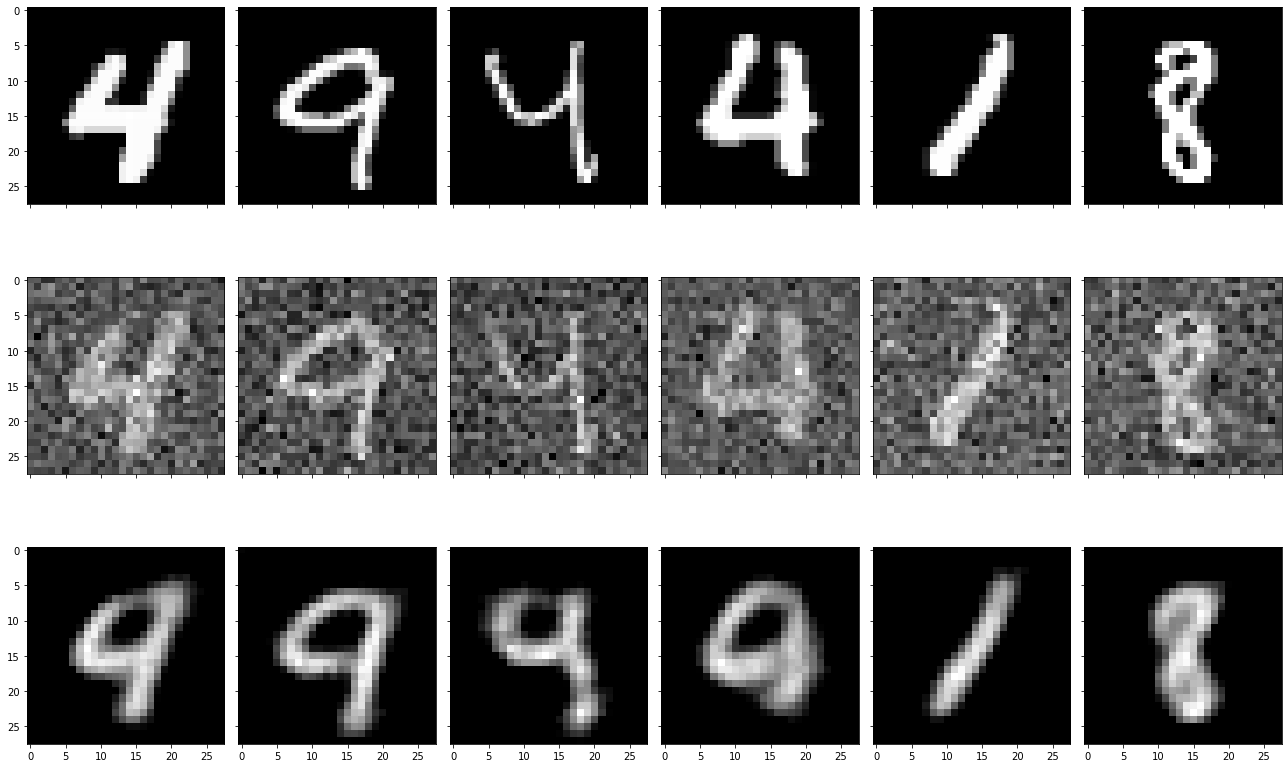

In [18]:
dae = DenoisingAutoEncoder(max_noise=0.3, annealing=False)
for epoch in range(4):
    dae.train(X_train)
dae.show(X_train, cols=6)

In [ ]:
dae = DenoisingAutoEncoder(max_noise=0.08, annealing=False)
for epoch in range(4):
    dae.train(X_train)
dae.show(X_train, cols=6)

In [21]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train = scale(X_train)
X_train.shape

(60000, 28, 28)

In [22]:
dae = DenoisingAutoEncoder(max_noise=0.3, annealing=False)
for epoch in range(4):
    dae.train(X_train)
dae.show(X_train, cols=6)

KeyboardInterrupt: 

In [ ]:
dae = DenoisingAutoEncoder(max_noise=0.05, annealing=False)
for epoch in range(4):
    dae.train(X_train)
dae.show(X_train, cols=6)

In [ ]:
def make_random_masks(X):
    X_mask = np.zeros(X.shape)
    for i in range(X.shape[0]):
        Xi = X[i, :, :]
        bh = np.random.choice((15, 10, 5))
        bw = np.random.choice((15, 10, 5))
        bi = np.random.choice((0, 5, 10, 18))
        bj = np.random.choice((0, 5, 10, 18))
        X_mask[i, bi:bi+bw, bj:bj+bh] = 1
    X_blocked = (X + X_mask)
    X_blocked = np.clip(X_blocked, 0, 1, out=X_blocked)
    return X_blocked

In [ ]:
class BlockingAutoEncoder(DenoisingAutoEncoder):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def train(self, X, y):
        n_batches = int(X.shape[0] / BATCH_SIZE)
        loss = 0
        x0 = 0
        x1 = BATCH_SIZE
        pbar = tqdm_notebook(range(n_batches), leave=False)
        for i in pbar:          
            batch = y[x0:x1, :, :].reshape(BATCH_SIZE, h, w, c)
            blocked_batch = X[x0:x1, :, :].reshape(BATCH_SIZE, h, w, c)
            loss = self.model.train_on_batch(blocked_batch, batch)         
            pbar.set_description('{} Loss:{:.2f}'.format(self.epochs, loss))
            x0 += BATCH_SIZE
            x1 += BATCH_SIZE             
        self.epochs += 1

    def show(self, X, y, cols=4):
        images = y[:cols, :, :].reshape(cols, h, w, c)
        image_blocked = X[:cols, :, :].reshape(cols, h, w, c)
        yhat = self.model.predict(image_blocked)
        fig, (real, noisy, pred) = plt.subplots(3, cols, figsize=(2*cols*1.5, 2*cols), sharex=True, sharey=True)
        for i, ax in enumerate(real):
            img = images[i, :, :, :]
            img = img.reshape(h, w)
            ax.imshow(img, cmap='gray')
        for i, ax in enumerate(noisy):
            img = image_blocked[i, :, :, :]
            img = img.reshape(h, w)
            ax.imshow(img, cmap='gray')
        for i, ax in enumerate(pred):
            img = yhat[i, :, :, :]
            img = img.reshape(h, w)
            ax.imshow(img, cmap='gray')
        plt.tight_layout()

In [ ]:
X = X_train.copy()
np.random.shuffle(X)
X = X.reshape(*X.shape, 1)
B = make_random_masks(X)

In [ ]:
bae = BlockingAutoEncoder()
for epoch in range(4):
    bae.train(B, X)

X = scale(X_test).copy()
np.random.shuffle(X)
X = X.reshape(*X.shape, 1)
B = make_random_masks(X)

bae.show(B, X)

In [ ]:
cols = 8
ints = np.random.randint(X.shape[0], size=cols)
bae.show(B[ints, :, :], X[ints, :, :], cols=cols)